In [1]:
import cv2
import pytesseract
from PIL import Image
import cv2
import argparse
import re
import os
import tempfile
import logging
import numpy as np
import nltk
from autocorrect import spell
from matplotlib import pyplot as plt
import PyPDF2
import io
from wand.image import Image
from PIL import Image as PI
import pyocr
import pyocr.builders
import io
from string import punctuation

In [279]:
file_path=r"James Jiang\Optical Character Recognition\receipt.png"

In [3]:
try:
    import Image
except ImportError:
    from PIL import Image
import pytesseract as tes

## 1. Data Visualization through adjusting different filters and see which one perform better (with a restaurant receipt)

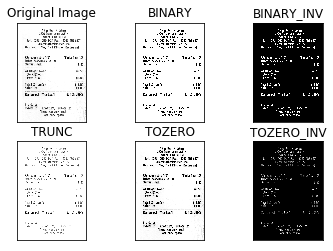

In [4]:
img = cv2.imread(file_path,0)
ret,thresh1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
ret,thresh2 = cv2.threshold(img,127,255,cv2.THRESH_BINARY_INV)
ret,thresh3 = cv2.threshold(img,127,255,cv2.THRESH_TRUNC)
ret,thresh4 = cv2.threshold(img,127,255,cv2.THRESH_TOZERO)
ret,thresh5 = cv2.threshold(img,127,255,cv2.THRESH_TOZERO_INV)

titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
images = [img, thresh1, thresh2, thresh3, thresh4, thresh5]

for i in range(6):
    plt.subplot(2,3,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

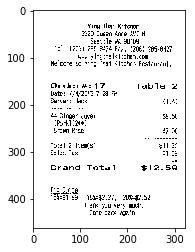

In [5]:
plt.imshow(thresh1,'gray')

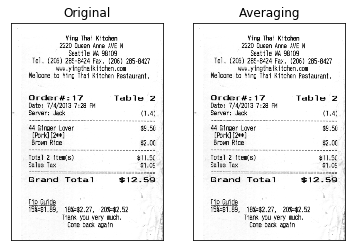

In [6]:
img = cv2.imread(file_path)

kernel = np.ones((1, 1), np.uint8)
dst = cv2.filter2D(img,-1,kernel)

plt.subplot(121),plt.imshow(img),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(dst),plt.title('Averaging')
plt.xticks([]), plt.yticks([])
plt.show()

In [7]:
img = cv2.imread(file_path)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,45,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

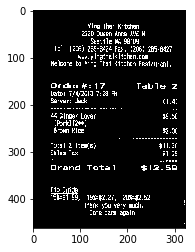

In [8]:
plt.imshow(thresh,'gray')

## 2. Pre-processing:create image noise-cleaning tools and dpi adjustment functions as below
<p> smooth image, remove noise and change dpi based on data visualization above in order to achieve better OCR performance.</p>

In [27]:
IMAGE_SIZE = 1500
BINARY_THREHOLD = 80

size = None

def get_size_of_scaled_image(im):
    global size
    if size is None:
        length_x, width_y = im.size
        factor = max(1, int(IMAGE_SIZE / length_x))
        size = factor * length_x, factor * width_y
    return size

In [10]:
def process_image_for_ocr(file_path):
    logging.info('Processing image for text Extraction')
    temp_filename = set_image_dpi(file_path)
    im_new = remove_noise_and_smooth(temp_filename)
    return im_new

In [11]:
def set_image_dpi(file_path):
    im = Image.open(file_path).convert('RGB')
    # size = (1800, 1800)
    size = get_size_of_scaled_image(im)
    im_resized = im.resize(size, Image.ANTIALIAS)
    temp_file = tempfile.NamedTemporaryFile(delete=False, suffix='.jpg')
    temp_filename = temp_file.name
    im_resized.save(temp_filename, dpi=(300, 300))  # best for OCR
    return temp_filename

In [12]:
def image_smoothening(img):
    ret1, th1 = cv2.threshold(img, BINARY_THREHOLD, 255, cv2.THRESH_BINARY)
    ret2, th2 = cv2.threshold(th1, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    blur = cv2.GaussianBlur(th2, (1, 1), 0)
    ret3, th3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return th3

In [13]:
def remove_noise_and_smooth(file_name):
    logging.info('Removing noise and smoothening image')
    img = cv2.imread(file_name, 0)
    filtered = cv2.adaptiveThreshold(img.astype(np.uint8), 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 41, 3)
    kernel = np.ones((1, 1), np.uint8)
    opening = cv2.morphologyEx(filtered, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    img = image_smoothening(img)
    or_image = cv2.bitwise_or(img, closing)
    return or_image

## 3. OCR output through Tesseract
<p> Use an example of a restaurant receipt after adjusting parameters above.</p>

In [15]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files (x86)\Tesseract-OCR\tesseract.exe'

In [296]:
results = tes.image_to_string(process_image_for_ocr(file_path), lang='eng', boxes=None, config='-psm 6')
print(results)

HOTEL UNIVERSAL RESORT
RJ SHIPS AND GIFT STORE
11/11/15 10:21am Ticket NO: 110595
T201 Shftzl Cshr 829 Guests:
Sa1esprsn:SMITH
ICE 3.00
COOLER 4 GAL 8.95
ARIZONA TEA 2.00 0 2.75 5.50
NECKACE SILVER/ BLUE 25.00
10% DISCOUNT (2.50)
PURSES (18.00) 18.00
Sub—tota]...: 60.45
Discount 2.50—
TAX 4.35
Total: 62.30
PAYMENT- CASH
THANK YOU
Notice: There no refunds on sa1e items.
Receipt/proof of purchase is required
for exchange.


## 4. Post-processing
<p> Use natural language processing to parse te total amount of payment from OCR.</p>

In [281]:
def extract_total_amount(string):
    end=None
    total=None
    Amount_RE_1 = r'(total).{0,10}\d{1,5}(.)?\d{0,2}'
    m = re.search(Amount_RE_1, string)
    total=m.group()
    return take_digit(total)

In [282]:
def strip_punctuation(string):
    return ''.join(c for c in string if c not in punctuation.replace(".",""))    

In [283]:
def take_digit(string):
    return ''.join(c for c in string if c.isdigit() or c==".")  

In [287]:
def auto_correction(string):
    token=nltk.word_tokenize(string)
    string1=" ".join(str(spell(x)) for x in token)
    return string1

In [284]:
post_processing_data=auto_correction(results).lower().replace('  ',' ').replace('subtotal','')

In [285]:
post_processing_data

'king thai kitchen 2220 cabby anne ave n seattle ha 98139 tel a a 206 a 285-8424 fax a a 206 a 285—8427 awu.y1ngtha1k1tcner.cam welcome tc king thai kitchen restaurant a order a :17 table a date a 7/4/2013 7228 ph server a jac a a the a of ginger laver a 9.50 a pork a a 2** a brown rice a 2.c0 total a item a s a a 11.50 sales tax a 1.09 grand total a 12.59 tip guide of a a a 1.89 a of a a a 2.27 a of a a a 2.52 thank yen very ch a come back again'

In [286]:
extract_total_amount(post_processing_data)

'12.59'

<p> try another receipt example.</p>

In [290]:
file_path_2=r"I:\James Jiang\Optical Character Recognition\receipt2.png"

In [292]:
results_2 = tes.image_to_string(process_image_for_ocr(file_path_2), lang='eng', boxes=None, config='-psm 6')

In [294]:
post_processing_data_2=auto_correction(results_2).lower().replace('  ',' ').replace('subtotal','')

In [295]:
extract_total_amount(post_processing_data_2)

'62.30'